In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
drive_path = '/content/drive/My Drive/'
files = os.listdir(drive_path)
print(files)


['Colab Notebooks', 'UTKFace', 'data.h5', 'Aml project 5th sem']


In [36]:

import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [37]:
import seaborn as sns

In [38]:
# Loading the Dataset:

path = '/content/drive/My Drive/UTKFace/'

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
8_1_0_20170109204452579.jpg.chip.jpg


In [ ]:
# Creating the Image, Ages and the Genders Array:

images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

In [ ]:
# Defining the function to display Images:

def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

In [ ]:
# Displaying an Image from the Dataset:

idx = 700
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [ ]:
# Function for defining the Age Groups:

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

In [ ]:
# Pre-processing:

target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]

features = features / 255

In [ ]:
display(features[550])

In [ ]:
# Splitting the Original Dataset into Training and Testing Dataset:

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

In [ ]:
# Defining the Model Layers:

inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [ ]:
# Compiling the Model:

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [ ]:
# Summary of the Model:

model.summary()

In [ ]:
# Training the Model:

h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 40, batch_size=128,shuffle = True)


Epoch 1/40
149/149 [==============================] - 495s 3s/step - loss: 0.7997 - dense_3_loss: 0.1056 - dense_9_loss: 0.6941 - dense_3_accuracy: 0.0128 - dense_9_accuracy: 0.5132 - val_loss: 0.7145 - val_dense_3_loss: 0.0311 - val_dense_9_loss: 0.6834 - val_dense_3_accuracy: 0.0261 - val_dense_9_accuracy: 0.5327
Epoch 2/40
149/149 [==============================] - 491s 3s/step - loss: 0.6910 - dense_3_loss: 0.0507 - dense_9_loss: 0.6403 - dense_3_accuracy: 0.0202 - dense_9_accuracy: 0.6255 - val_loss: 0.5690 - val_dense_3_loss: 0.0289 - val_dense_9_loss: 0.5402 - val_dense_3_accuracy: 0.0249 - val_dense_9_accuracy: 0.7845
Epoch 3/40
149/149 [==============================] - 487s 3s/step - loss: 0.6079 - dense_3_loss: 0.0415 - dense_9_loss: 0.5664 - dense_3_accuracy: 0.0228 - dense_9_accuracy: 0.7629 - val_loss: 0.5121 - val_dense_3_loss: 0.0263 - val_dense_9_loss: 0.4858 - val_dense_3_accuracy: 0.0264 - val_dense_9_accuracy: 0.7990
Epoch 4/40
149/149 [=============================

In [ ]:
# Saving the Model:

model.save('/content/drive/My Drive/data.h5')

In [ ]:
# Defining the functions for getting the Predictions:

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)

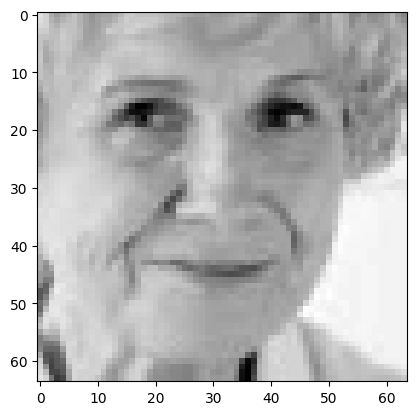

Actual Gender: Female Age: 82
1/1 [==============================] - 0s 42ms/step
Values: [array([[0.6641695]], dtype=float32), array([[0.87939745]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


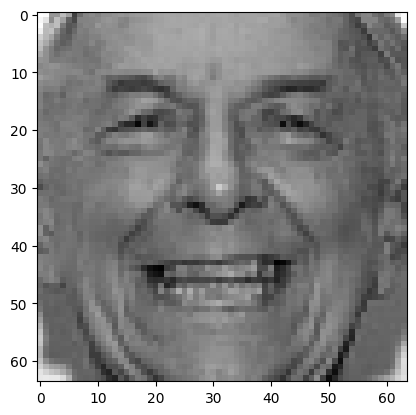

Actual Gender: Male Age: 74
1/1 [==============================] - 0s 34ms/step
Values: [array([[0.7375993]], dtype=float32), array([[8.3480267e-10]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


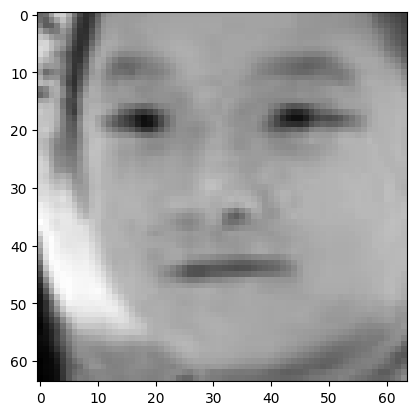

Actual Gender: Female Age: 7
1/1 [==============================] - 0s 36ms/step
Values: [array([[0.30533624]], dtype=float32), array([[0.87939745]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 0-18


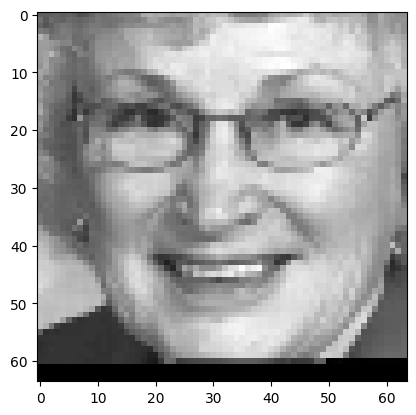

Actual Gender: Female Age: 85
1/1 [==============================] - 0s 29ms/step
Values: [array([[0.7278043]], dtype=float32), array([[0.87939745]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


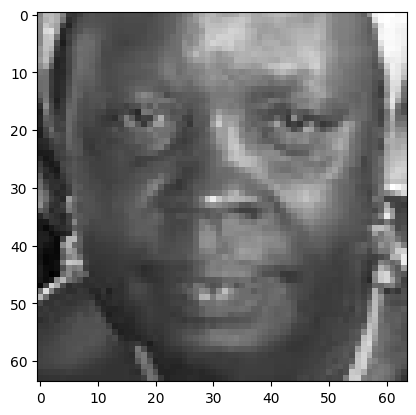

Actual Gender: Female Age: 58
1/1 [==============================] - 0s 31ms/step
Values: [array([[0.70201993]], dtype=float32), array([[0.45700714]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


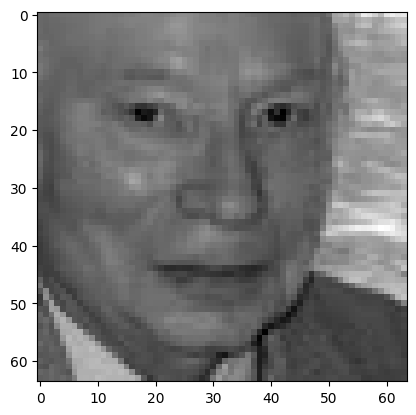

Actual Gender: Male Age: 80
1/1 [==============================] - 0s 30ms/step
Values: [array([[0.7148913]], dtype=float32), array([[0.33277673]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


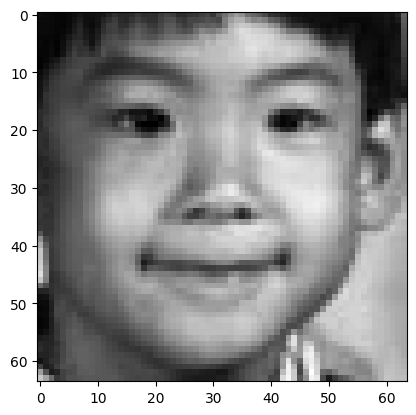

Actual Gender: Male Age: 8
1/1 [==============================] - 0s 37ms/step
Values: [array([[0.3108595]], dtype=float32), array([[0.87939745]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 0-18


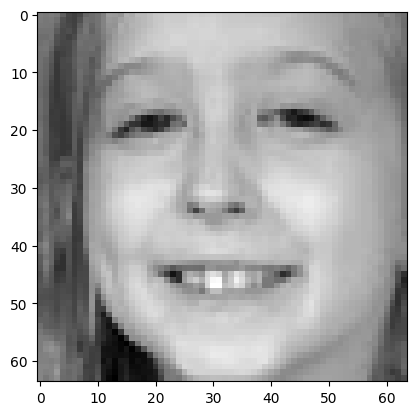

Actual Gender: Female Age: 8
1/1 [==============================] - 0s 29ms/step
Values: [array([[0.31359887]], dtype=float32), array([[0.87939745]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 0-18


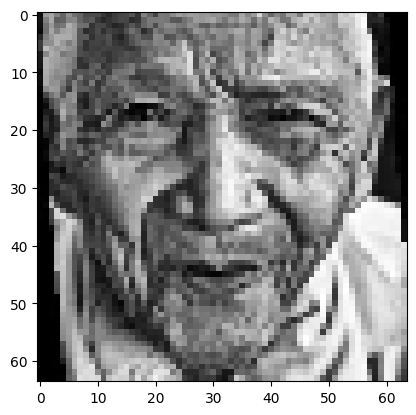

Actual Gender: Male Age: 90
1/1 [==============================] - 0s 31ms/step
Values: [array([[0.8033311]], dtype=float32), array([[3.4824858e-05]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


In [ ]:
# Taking the predictions for a set of sample data points:

indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)

In [3]:
import cv2
import numpy as np
from tensorflow import keras

# Load your model
model = keras.models.load_model('/content/drive/My Drive/data.h5')



In [20]:
from PIL import Image

# Open the image using PIL
image = Image.open('/content/download (4).jpg')  # Replace 'path_to_your_image.jpg' with your image file

# Convert the image to grayscale
gray_image = image.convert('L')

# Save or display the grayscale image
gray_image.save('/content/download (4)greyscale.jpg')  # Save the grayscale image
gray_image.show()  # Display the grayscale image


In [35]:
import cv2
import numpy as np

# Define the post-processing functions
def get_age(distr):
    distr = distr * 4
    if 0.65 <= distr <= 1.4:
        return "0-18"
    if 1.65 <= distr <= 2.4:
        return "19-30"
    if 2.65 <= distr <= 3.4:
        return "31-80"
    if 3.65 <= distr <= 4.4:
        return "80+"
    return "Unknown"

def get_gender(prob):
    return "Female" if prob >= 0.5 else "Male"

def get_result(sample):
    sample = sample / 255.0
    val = model.predict(np.array([sample]))
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:", val, "\nPredicted Gender:", gender, "Predicted Age:", age)

# Load and preprocess the new image
new_image_path = '/content/download (4).jpg'  # Replace with the actual path to your greyscale image
new_image = cv2.imread(new_image_path, 0)  # Read as grayscale
new_image = cv2.resize(new_image, dsize=(64, 64))
input_data = new_image.reshape((new_image.shape[0], new_image.shape[1], 1))

# Make predictions and apply post-processing
get_result(input_data)


1/1 [==============================] - 0s 57ms/step
Values: [array([[0.59152704]], dtype=float32), array([[1.5194863e-06]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30
